In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict

In [2]:
def a_star_shortest_path(field_init, init_point, destination_point, diags=False):

  field = np.copy(field_init)
  field[field > 1] = 0
  
  A_x, A_y = init_point[0], init_point[1]
  B_x, B_y = destination_point[0], destination_point[1]
  field[A_x][A_y] = 0
  field[B_x][B_y] = 0

  g_function = np.zeros(np.array(field).shape) # функция g(x) для всех ячеек (-1 - функция ещё не посчитана)
  g_function -= 1
  g_function = g_function.astype(int)

  h_function = np.zeros(np.array(field).shape) # функция h(x) для всех ячеек (-1 - функция ещё не посчитана)
  h_function -= 1
  h_function = g_function.astype(int)
  
  parents_X = np.zeros(np.array(field).shape) # X-координата ячейки-родителя для восстановления ответа (-1 - родитель не определен)
  parents_X -= 1
  parents_X = parents_X.astype(int)

  parents_Y = np.zeros(np.array(field).shape) # Y-координата ячейки-родителя для восстановления ответа (-1 - родитель не определен)
  parents_Y -= 1
  parents_Y = parents_Y.astype(int)

  open_list = [(A_x, A_y)] # открытый список
  closed_list = set() # закрытый список

  g_function[A_x][A_y] = 0 # расстояние от исходной ячейки до себя же равно нулю
  h_function[A_x][A_y] = 10 * (abs(B_x - A_x) + abs(B_y - A_y)) # манхэттенское расстояние от исходной ячейки до конечной, умноженное на 10

  while len(open_list) > 0:

    max_index = -1
    min_value = 1E6

    for k in range(len(open_list)): # выбираем ячейку с минимальным значением функции f(x) = g(x) + h(x)
      if g_function[open_list[k][0]][open_list[k][1]] + h_function[open_list[k][0]][open_list[k][1]] < min_value:
        min_value = g_function[open_list[k][0]][open_list[k][1]] + h_function[open_list[k][0]][open_list[k][1]]
        max_index = k

    cur_point = open_list[max_index]

    if cur_point[0] == B_x and cur_point[1] == B_y: # мы дошли до точки назначения
      break
    
    open_list.pop(max_index)

    for x in range(-1, 2): 
      for y in range(-1, 2): # перебираем всех соседей
        if abs(x) + abs(y) == 0: # нельзя идти из клетки в себя же
          continue
        if abs(x) + abs(y) > 1 and not diags: # нельзя идти по диагонали, если diags=False
          continue
        new_point_X = cur_point[0] + x
        new_point_Y = cur_point[1] + y
        if new_point_X < 0 or new_point_X >= g_function.shape[0] or new_point_Y < 0 or new_point_Y >= g_function.shape[1]: # ячейка выходит за пределы поля
          continue
        if field[new_point_X][new_point_Y] != 0: # стена
          continue
        if (new_point_X, new_point_Y) in open_list or (new_point_X, new_point_Y) in closed_list: # мы здесь уже были
          continue

        # если мы все-таки дошли сюда, обновляем значения функций и родительскую ячейку
        g_function[new_point_X][new_point_Y] = g_function[cur_point[0]][cur_point[1]] + 10 # всегда добавляем 10
        if abs(x) + abs(y) > 1:
          g_function[new_point_X][new_point_Y] += 4 # если пришли по диагонали, добавляем ещё 4, то есть в сумме 14

        # манхэттенское расстояние до конечной ячейки, умноженное на 10
        h_function[new_point_X][new_point_Y] = 10 * (abs(B_x - new_point_X) + abs(B_y - new_point_Y))

        parents_X[new_point_X][new_point_Y] = cur_point[0]
        parents_Y[new_point_X][new_point_Y] = cur_point[1]

        open_list.append((new_point_X, new_point_Y))
    
    closed_list.add(cur_point)
  
  total_path = [(B_x, B_y)] # восстанавливаем путь

  cur_point = (B_x, B_y)
  while cur_point != (A_x, A_y):
    if cur_point[0] == -1 or cur_point[1] == -1:
      return []
    next_point = (parents_X[cur_point[0]][cur_point[1]], parents_Y[cur_point[0]][cur_point[1]])
    total_path.append(next_point)
    cur_point = next_point

  total_path = list(reversed(total_path))
  return total_path

In [3]:
def generate_position(field_height, fiend_width, walls_count, enemies_smart):
  field = np.zeros(shape=field_height * fiend_width)
  field[:walls_count] = 1
  field[walls_count: walls_count + enemies_smart] = 2
  field[walls_count + enemies_smart] = 3
  field[walls_count + enemies_smart + 1] = 4

  while True:
    np.random.shuffle(field)
    field_reshaped = field.reshape((field_height, fiend_width))

    res_st = np.where(field_reshaped == 3)
    res_end = np.where(field_reshaped == 4)

    sh_path = a_star_shortest_path(field_reshaped, (res_st[0][0], res_st[1][0]), (res_end[0][0], res_end[1][0]))
    if len(sh_path) > 0:
      return field_reshaped

In [4]:
class Game:

  def __init__(self, height, width, walls_count, enemies_count, depth=5):
    self.field = generate_position(height, width, walls_count, enemies_count)
    self.agent_active = 0
    self.label_list = ['free', 'wall', 'enemies_pos', 'pacman_pos', 'end_pos']
    self.depth = depth
    self.enemies_count = enemies_count

    res = np.where(self.field == len(self.label_list) - 1)
    self.end_position = tuple(zip(res[0], res[1]))[0]
    self.field[self.end_position[0]][self.end_position[1]] = 0


  def get_coord_dict(self, position=None):
    coord_dict = defaultdict(list)

    if position is None:
      position = self.field

    for k in range(2, len(self.label_list)):
      res = np.where(self.field == k)
      for t in list(zip(res[0], res[1])):
        coord_dict[self.label_list[k]].append(t)

    return coord_dict


  def dist_to_smart(self, position=None):

    if position is None:
      position = self.field

    coord_dict = self.get_coord_dict(position)
    start_coords = coord_dict['pacman_pos'][0]

    dist_to_enemies_smart = 1E6

    for k in coord_dict['enemies_pos']:
      sh_path_to_smart = a_star_shortest_path(position, start_coords, k)
      cur_dist = len(sh_path_to_smart) - 1
      #cur_dist = abs(start_coords[0] - k[0]) + abs(start_coords[1] - k[1])
      dist_to_enemies_smart = min(dist_to_enemies_smart, cur_dist)

    return dist_to_enemies_smart


  def evaluate_position(self, position=None, agent_active=None):

    if position is None:
      position = self.field

    if agent_active is None:
      agent_active = self.agent_active

    game_over = self.is_game_over(position, agent_active)
    if game_over != 0:
      return game_over
    
    coord_dict = self.get_coord_dict(position)
    dist_to_enemies_smart = self.dist_to_smart(position)

    start_coords = coord_dict['pacman_pos'][0]
    end_coords = self.end_position

    #sh_path_to_end = a_star_shortest_path(position, start_coords, end_coords)
    #dist_to_end_pos = len(sh_path_to_end) - 1
    dist_to_end_pos = abs(start_coords[0] - end_coords[0]) + abs(start_coords[1] - end_coords[1])

    #return dist_to_enemies_smart - dist_to_end_pos
    return dist_to_enemies_smart - 10 * dist_to_end_pos


  def get_legal_moves(self, position=None, agent_active=None):

    if position is None:
      position = self.field

    if agent_active is None:
      agent_active = self.agent_active

    if agent_active == 0:
      cur_key = 'pacman_pos'
    else:
      cur_key = 'enemies_pos'

    coord_dict = self.get_coord_dict(position)
    dirs_deltas = [(+0, -1), (+1, +0), (+0, +1), (-1, +0)]

    cur_pos = coord_dict[cur_key][max(0, agent_active - 1)]
    cur_moves = []

    for d in dirs_deltas:
      next_pos_X, next_pos_Y = cur_pos[0] + d[0], cur_pos[1] + d[1]
      if next_pos_X < 0 or next_pos_X >= len(position):
        continue
      if next_pos_Y < 0 or next_pos_Y >= len(position[0]):
        continue
      if position[next_pos_X][next_pos_Y] not in (1, 2):
        cur_moves.append((next_pos_X, next_pos_Y))
      
    return cur_pos, cur_moves


  def is_game_over(self, position=None, agent_active=None):

    if position is None:
      position = self.field

    if agent_active is None:
      agent_active = self.agent_active
    
    coord_dict = self.get_coord_dict(position)
    pacman_coords = coord_dict['pacman_pos'][0]

    cur_pos, legal_moves = self.get_legal_moves(position, agent_active)
    if agent_active == 0 and self.end_position in legal_moves:
      return 1E6
    if agent_active > 0 and pacman_coords in legal_moves:
      return -1E6
    
    return 0


  def maximizer(self, agent, depth, game_state, a, b):  # maximizer function
    v = float("-inf")

    cur_pos, new_positions = self.get_legal_moves(game_state, agent)
    for new_pos in new_positions:
      new_game_state = np.copy(game_state)
      new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
      new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]

      v = max(v, self.alphabetaprune(1, depth, new_game_state, a, b))
      if v > b:
        return v
      a = max(a, v)
    return v


  def minimizer(self, agent, depth, game_state, a, b):  # minimizer function
    v = float("inf")

    next_agent = agent + 1  # calculate the next agent and increase depth accordingly.
    if self.enemies_count <= next_agent:
      next_agent = 0
    
    if next_agent == 0:
      depth += 1

    cur_pos, new_positions = self.get_legal_moves(game_state, agent)
    for new_pos in new_positions:
      new_game_state = np.copy(game_state)
      new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
      new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]

      v = min(v, self.alphabetaprune(next_agent, depth, new_game_state, a, b))
      if v < a:
        return v
      b = min(b, v)
    return v
  

  def alphabetaprune(self, agent, depth, game_state, a, b):
    if self.is_game_over(game_state, agent) != 0 or depth == self.depth:  # return the utility in case the defined depth is reached or the game is won/lost.
      return self.evaluate_position(game_state, agent)

    if agent == 0:  # maximize for pacman
      return self.maximizer(agent, depth, game_state, a, b)
    else:  # minimize for enemies
      return self.minimizer(agent, depth, game_state, a, b)


  def expectimax(self, agent, depth, game_state):
    if self.is_game_over(game_state, agent) != 0 or depth == self.depth:  # return the utility in case the defined depth is reached or the game is won/lost.
      return self.evaluate_position(game_state)

    if agent == 0:  # maximize for pacman
      v = float("-inf")
      cur_pos, new_positions = self.get_legal_moves(game_state, agent)
      for new_pos in new_positions:
        new_game_state = np.copy(game_state)
        new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
        new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]
        v = max(v, self.expectimax(1, depth, new_game_state))
      return v
    else:
      next_agent = agent + 1
      if self.enemies_count <= next_agent:
        next_agent = 0
    
      if next_agent == 0:
        depth += 1

      v = 0
      cur_pos, new_positions = self.get_legal_moves(game_state, agent)
      for new_pos in new_positions:
        new_game_state = np.copy(game_state)
        new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
        new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]
        v += self.expectimax(next_agent, depth, new_game_state)
      return v / len(new_positions)


  def make_pacman_move(self, expectimax):
    utility = float("-inf")
    move = None
    alpha = float("-inf")
    beta = float("inf")

    cur_pos, new_positions = self.get_legal_moves(self.field, 0)
    for new_pos in new_positions:
      new_game_state = np.copy(self.field)
      new_game_state[cur_pos[0]][cur_pos[1]] = self.field[new_pos[0]][new_pos[1]]
      new_game_state[new_pos[0]][new_pos[1]] = self.field[cur_pos[0]][cur_pos[1]]
      
      if expectimax:
        enemies_value = self.expectimax(1, 0, new_game_state)
      else:
        enemies_value = self.alphabetaprune(1, 0, new_game_state, alpha, beta)

      if enemies_value > utility:
        utility = enemies_value
        move = (cur_pos, new_pos)
        alpha = max(alpha, utility)

    if move is None:
      move = (cur_pos, cur_pos)

    return move


  def play_one_move(self, expectimax):

    cur_pos, new_pos = self.make_pacman_move(expectimax)
    if new_pos == self.end_position:
      return 1E6

    new_game_state = np.copy(self.field)
    new_game_state[cur_pos[0]][cur_pos[1]] = self.field[new_pos[0]][new_pos[1]]
    new_game_state[new_pos[0]][new_pos[1]] = self.field[cur_pos[0]][cur_pos[1]]

    self.field = new_game_state

    print('Pacman move: ' + str(cur_pos) + '->' + str(new_pos))

    if new_game_state[self.end_position[0]][self.end_position[1]] == 0:
      new_game_state[self.end_position[0]][self.end_position[1]] = 4

    plt.figure(figsize=(10, 10))
    plt.imshow(new_game_state)
    plt.show()
      
    coord_dict = self.get_coord_dict()
    pacman_coords = coord_dict['pacman_pos'][0]
    enemies_coords = coord_dict['enemies_pos']

    new_game_state = np.copy(self.field)

    for k in range(self.enemies_count):
      cur_path_to_pacman = a_star_shortest_path(self.field, enemies_coords[k], pacman_coords)
      if len(cur_path_to_pacman) < 2 or self.field[cur_path_to_pacman[1][0]][cur_path_to_pacman[1][1]] in (1, 2):
        best_move = enemies_coords[k]
      elif len(cur_path_to_pacman) == 2:
        return -1E6
      else:
        best_move = cur_path_to_pacman[1]

      new_game_state = np.copy(self.field)
      new_game_state[enemies_coords[k][0]][enemies_coords[k][1]] = self.field[best_move[0]][best_move[1]]
      new_game_state[best_move[0]][best_move[1]] = self.field[enemies_coords[k][0]][enemies_coords[k][1]]
      self.field = new_game_state

      print('Enemy {} move: '.format(k + 1) + str(enemies_coords[k]) + '->' + str(best_move))

    if new_game_state[self.end_position[0]][self.end_position[1]] == 0:
      new_game_state[self.end_position[0]][self.end_position[1]] = 4
    
    plt.figure(figsize=(10, 10))
    plt.imshow(new_game_state)
    plt.show()

    return 0

  
  def play(self, expectimax=False):

    print('Initial position:')

    new_game_state = np.copy(self.field)
    if new_game_state[self.end_position[0]][self.end_position[1]] == 0:
      new_game_state[self.end_position[0]][self.end_position[1]] = 4

    plt.figure(figsize=(10, 10))
    plt.imshow(new_game_state)
    plt.show()

    for moves in range(50):
      is_game_over = self.play_one_move(expectimax)
      if is_game_over < 0:
        print('Enemies win.')
        return
      elif is_game_over > 0:
        print('Pacman wins!')
        return

    print('Draw after 50 moves!')

In [5]:
game = Game(10, 10, 15, 3, 2)

Initial position:


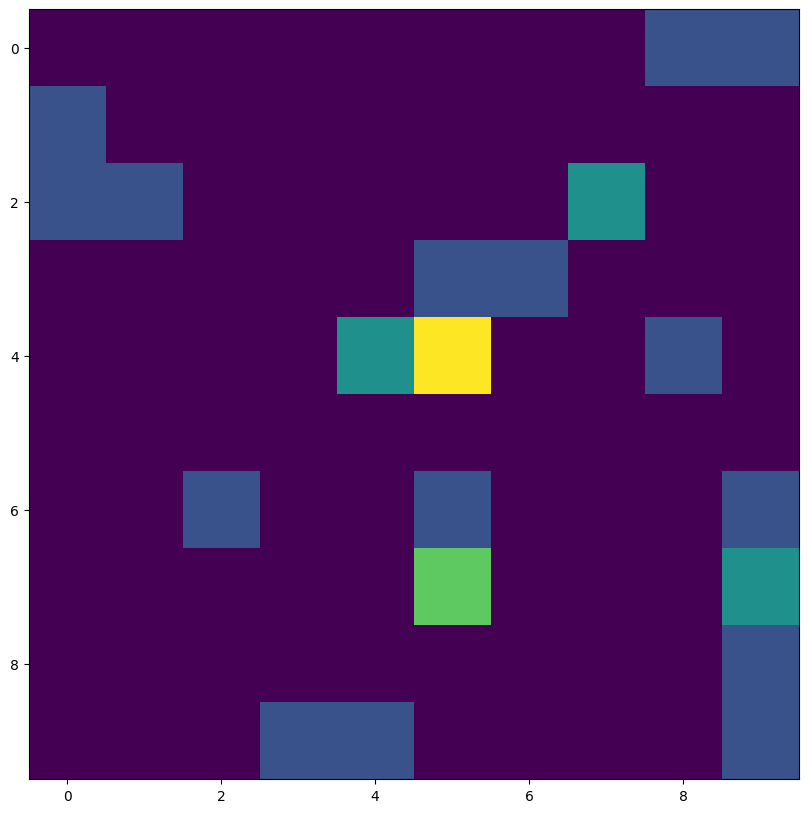

Pacman move: (7, 5)->(7, 4)


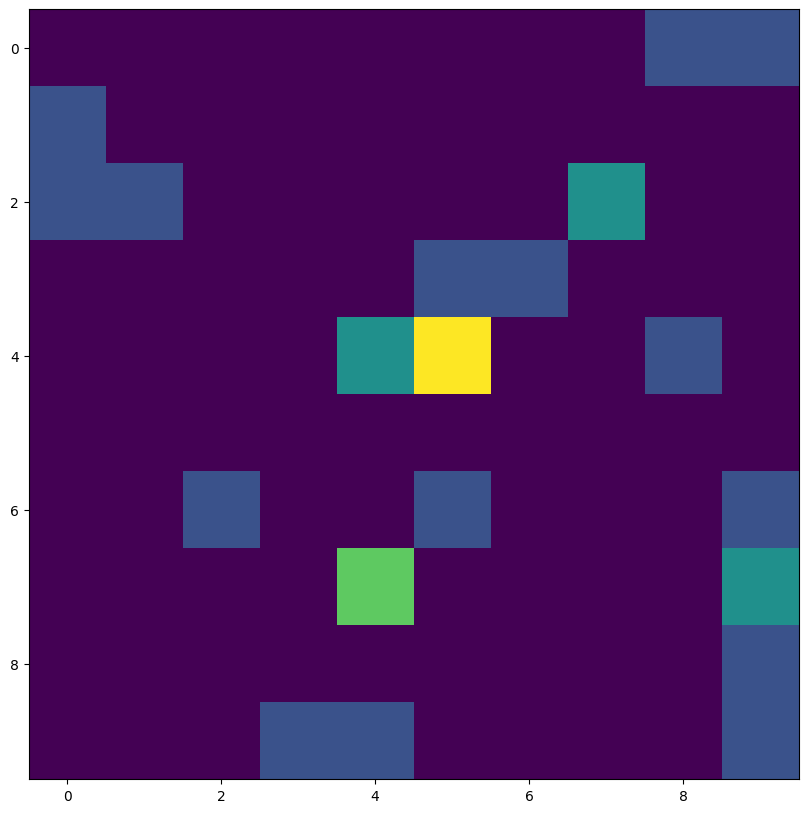

Enemy 1 move: (2, 7)->(2, 6)
Enemy 2 move: (4, 4)->(5, 4)
Enemy 3 move: (7, 9)->(7, 8)


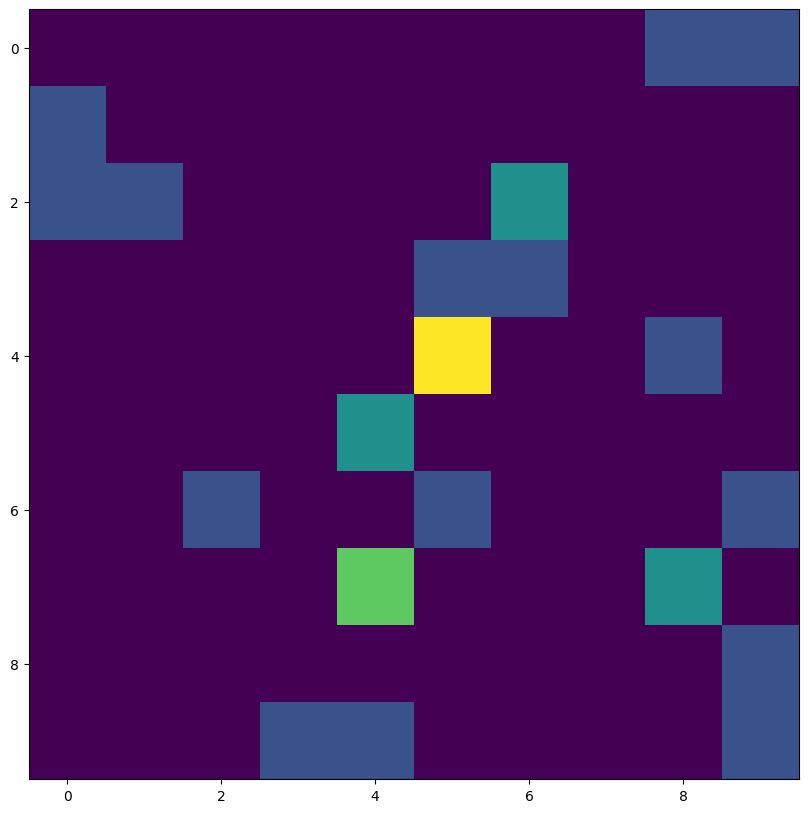

Pacman move: (7, 4)->(7, 3)


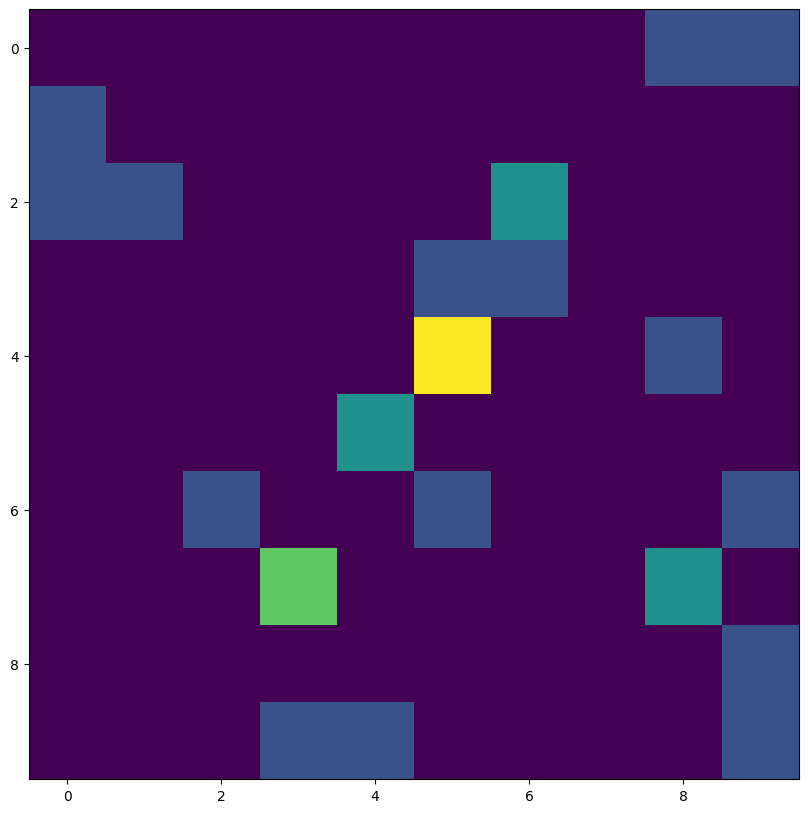

Enemy 1 move: (2, 6)->(2, 5)
Enemy 2 move: (5, 4)->(5, 3)
Enemy 3 move: (7, 8)->(7, 7)


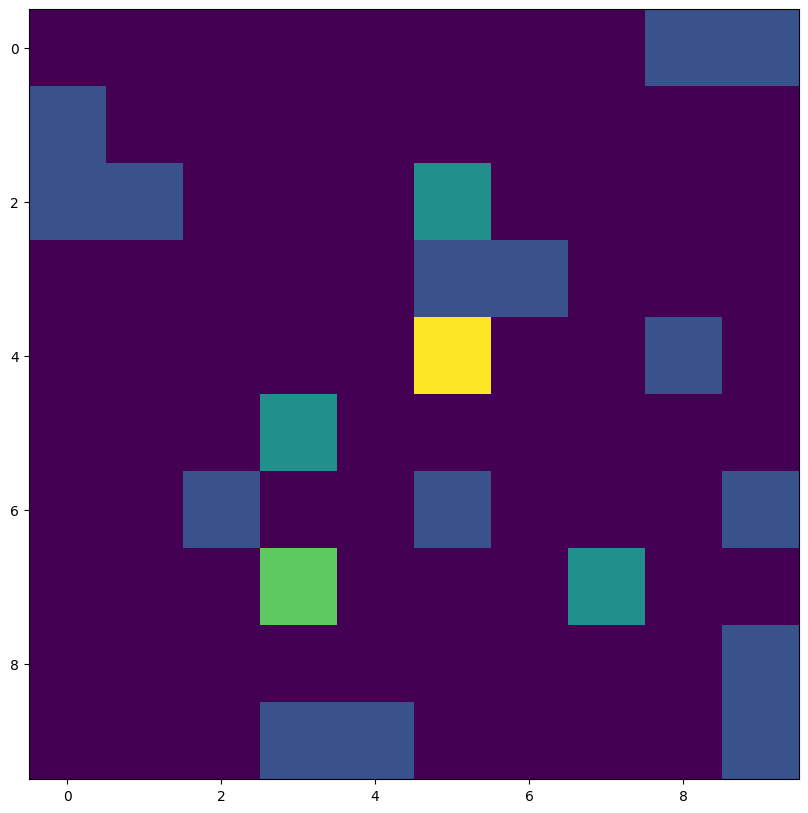

Pacman move: (7, 3)->(7, 2)


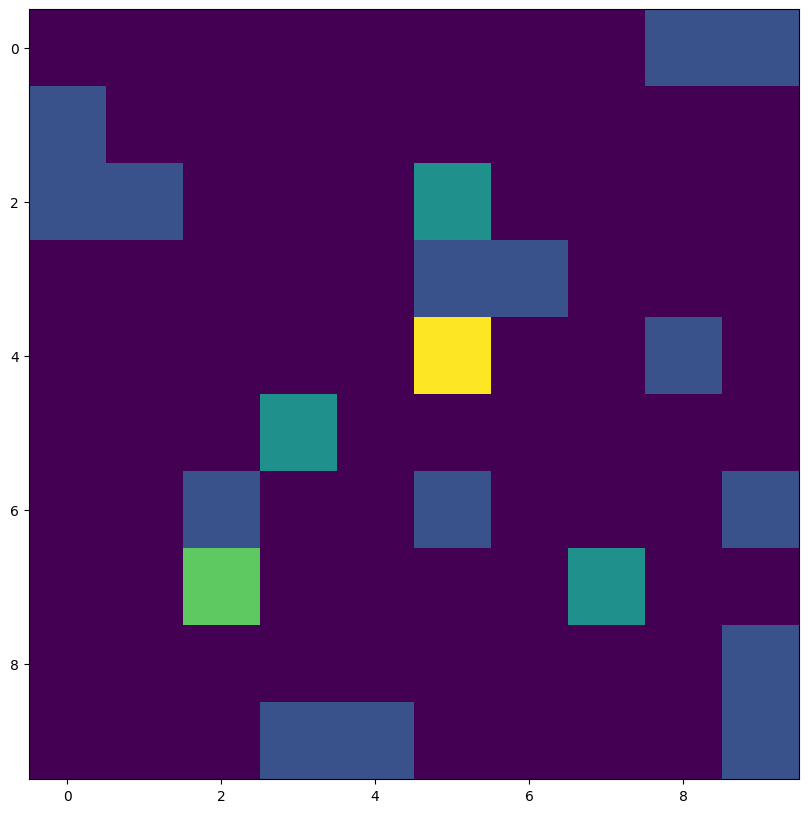

Enemy 1 move: (2, 5)->(2, 4)
Enemy 2 move: (5, 3)->(6, 3)
Enemy 3 move: (7, 7)->(7, 6)


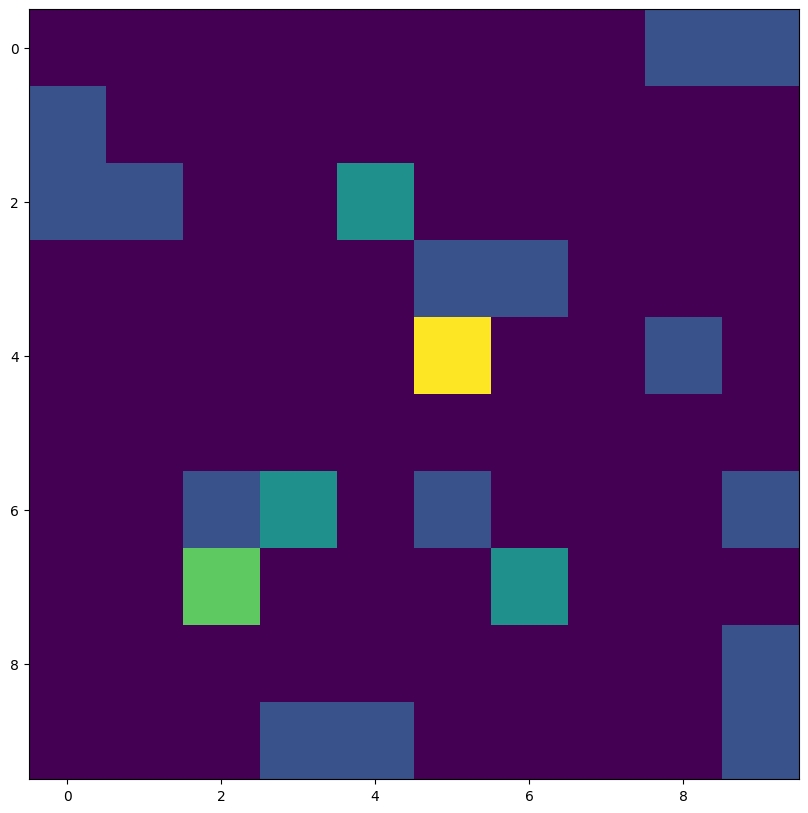

Pacman move: (7, 2)->(7, 1)


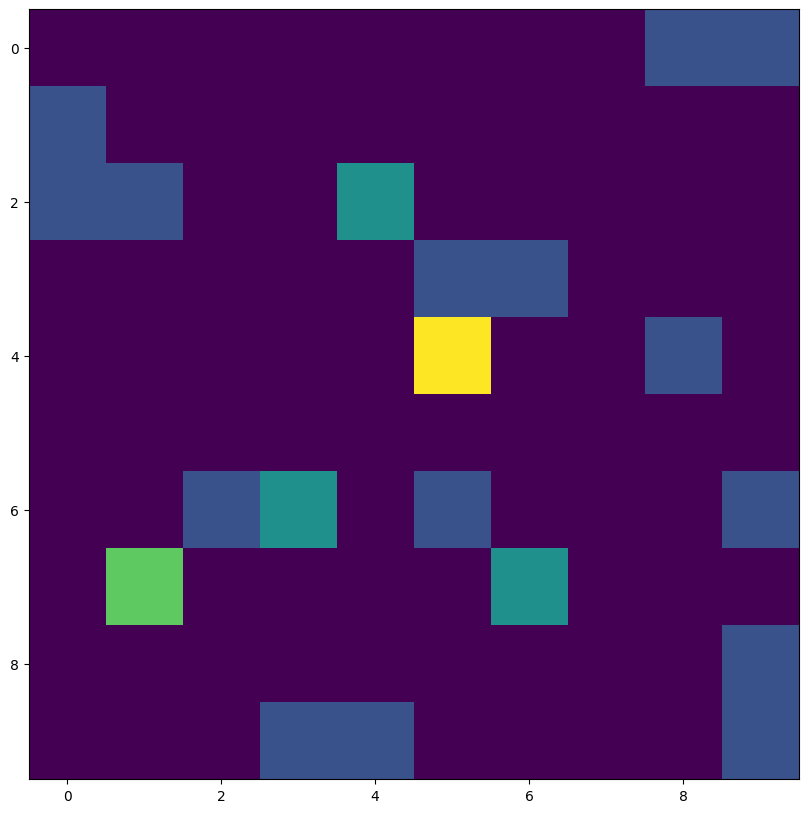

Enemy 1 move: (2, 4)->(2, 3)
Enemy 2 move: (6, 3)->(7, 3)
Enemy 3 move: (7, 6)->(7, 5)


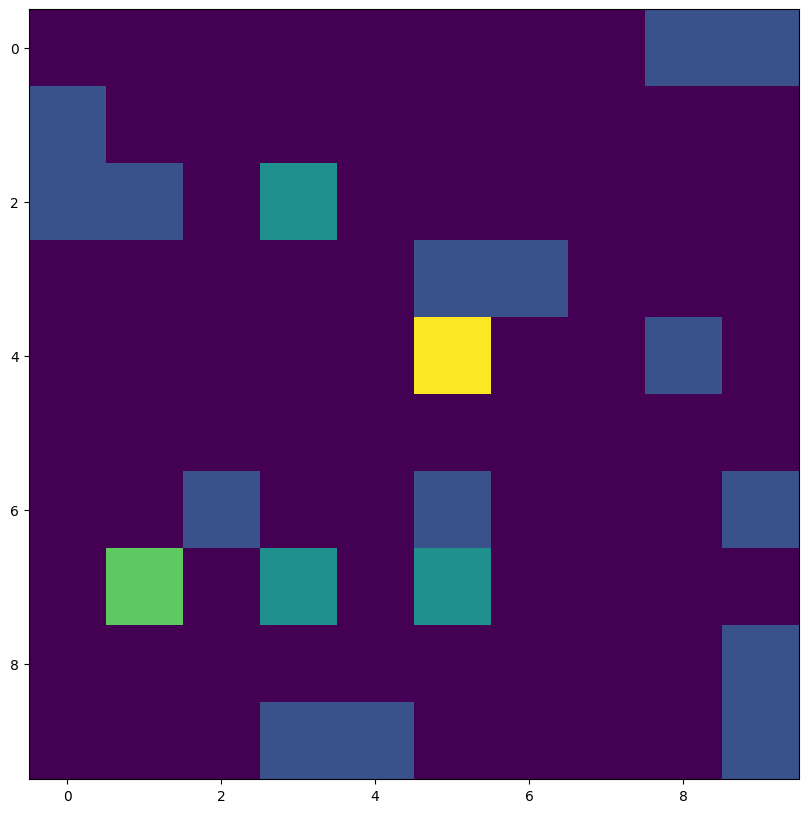

Pacman move: (7, 1)->(7, 0)


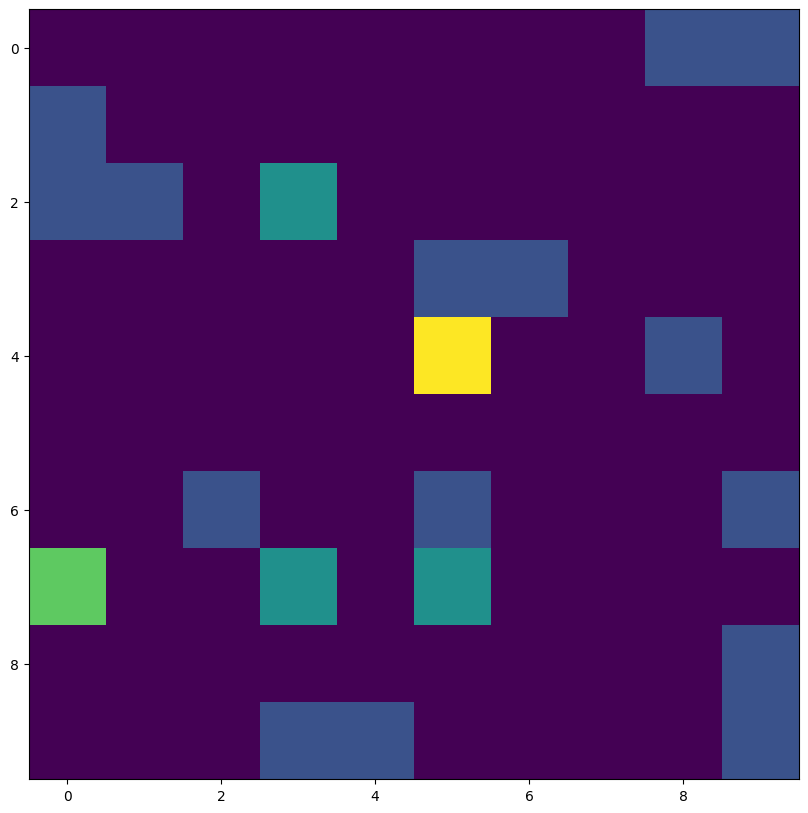

Enemy 1 move: (2, 3)->(2, 2)
Enemy 2 move: (7, 3)->(7, 2)
Enemy 3 move: (7, 5)->(7, 4)


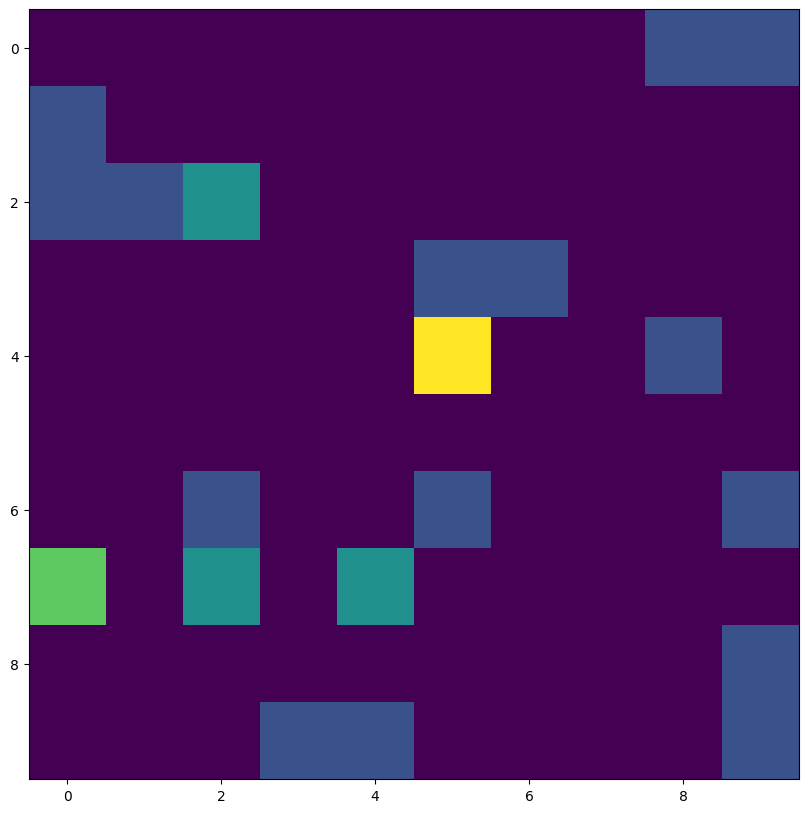

Pacman move: (7, 0)->(8, 0)


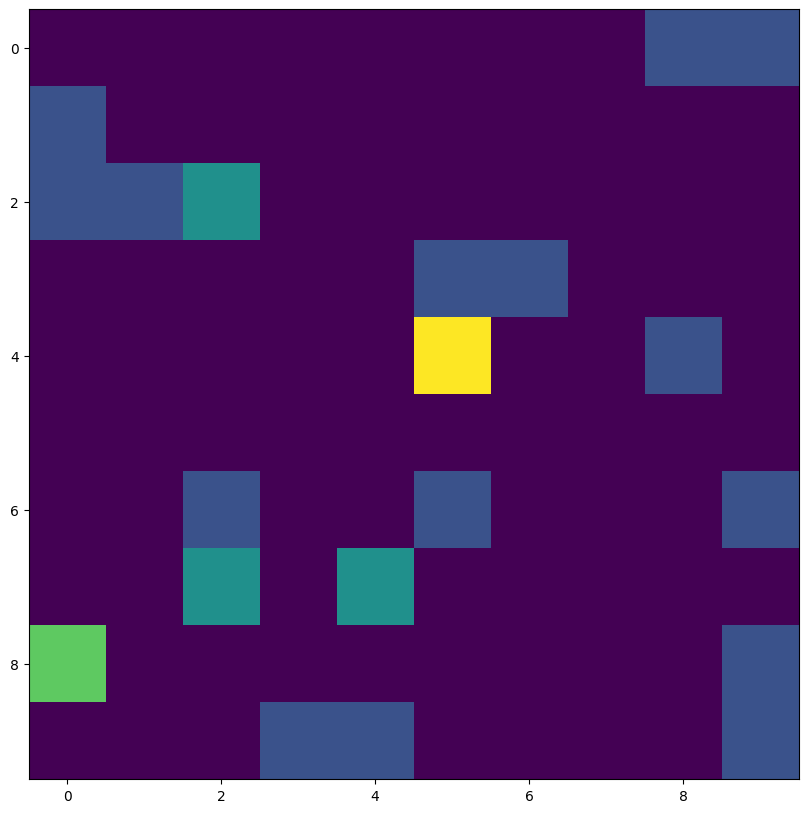

Enemy 1 move: (2, 2)->(3, 2)
Enemy 2 move: (7, 2)->(7, 1)
Enemy 3 move: (7, 4)->(7, 3)


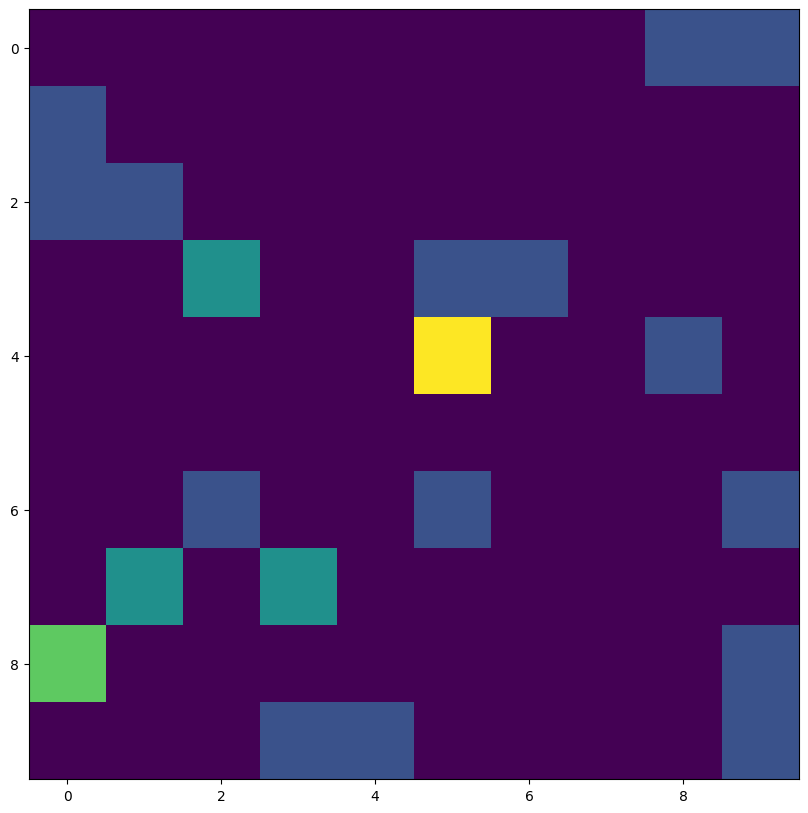

Pacman move: (8, 0)->(9, 0)


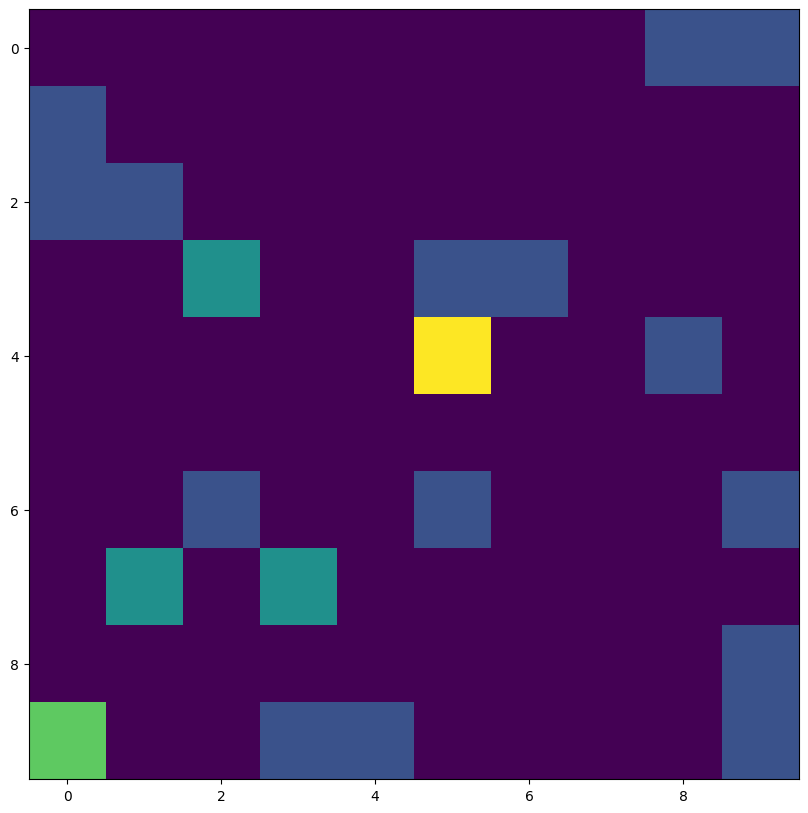

Enemy 1 move: (3, 2)->(3, 1)
Enemy 2 move: (7, 1)->(7, 0)
Enemy 3 move: (7, 3)->(7, 2)


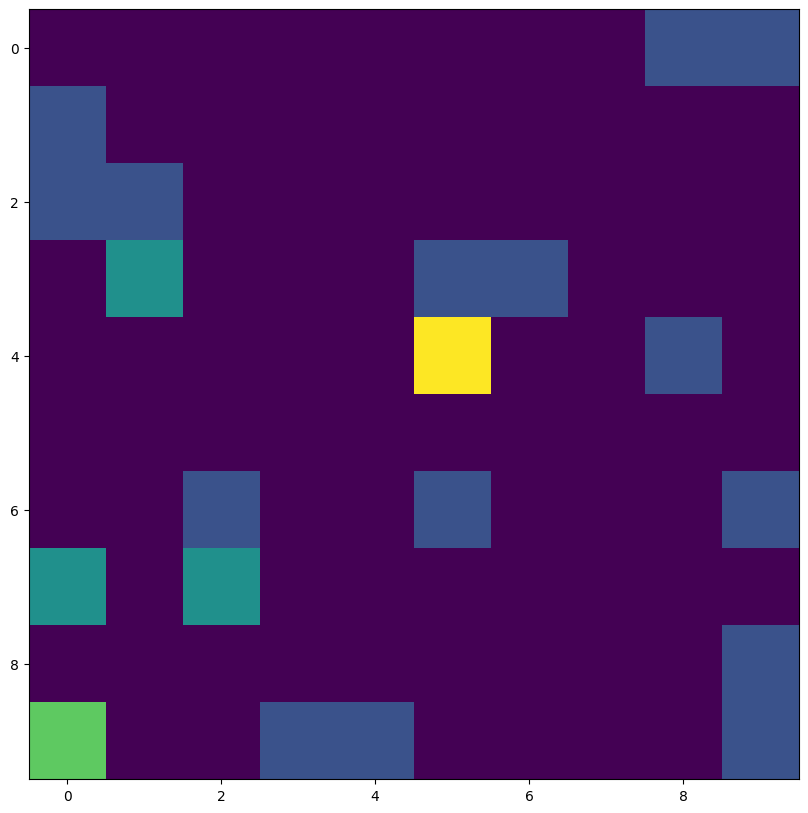

Pacman move: (9, 0)->(9, 1)


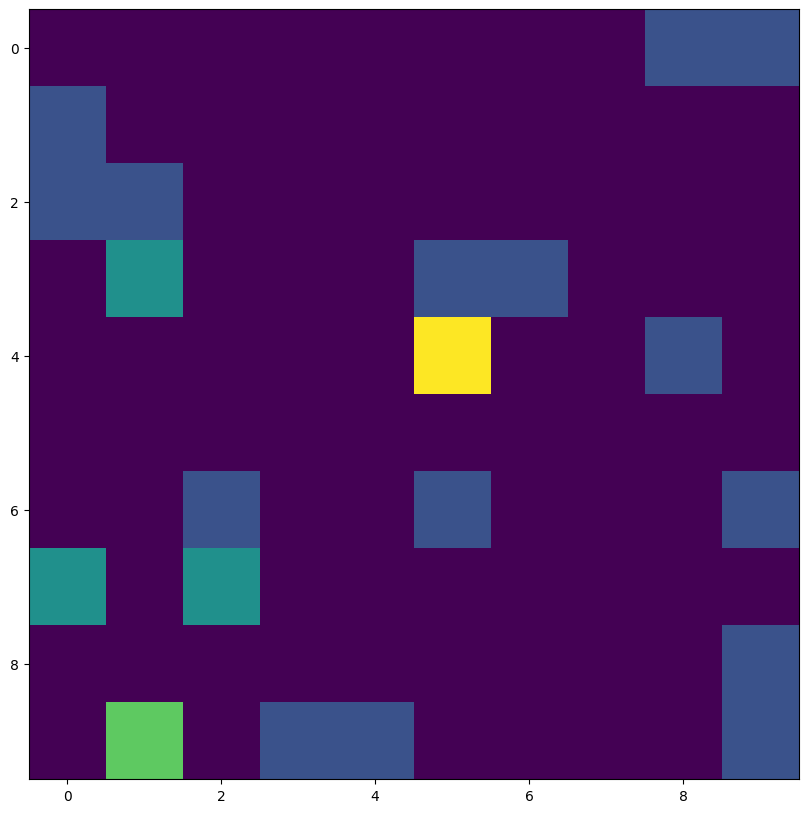

Enemy 1 move: (3, 1)->(4, 1)
Enemy 2 move: (7, 0)->(7, 1)
Enemy 3 move: (7, 2)->(7, 2)


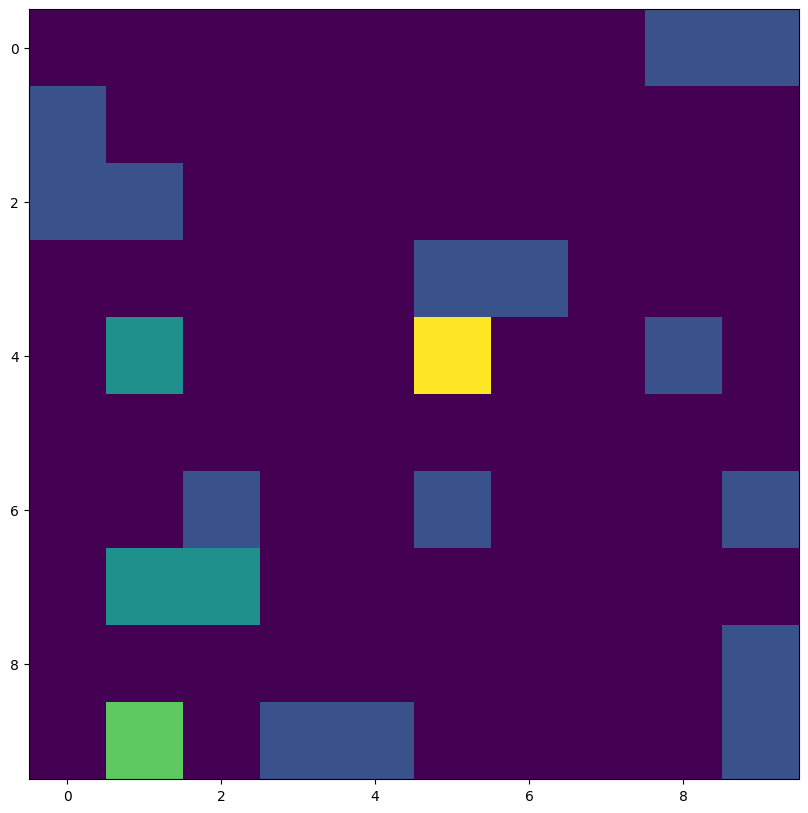

Pacman move: (9, 1)->(9, 0)


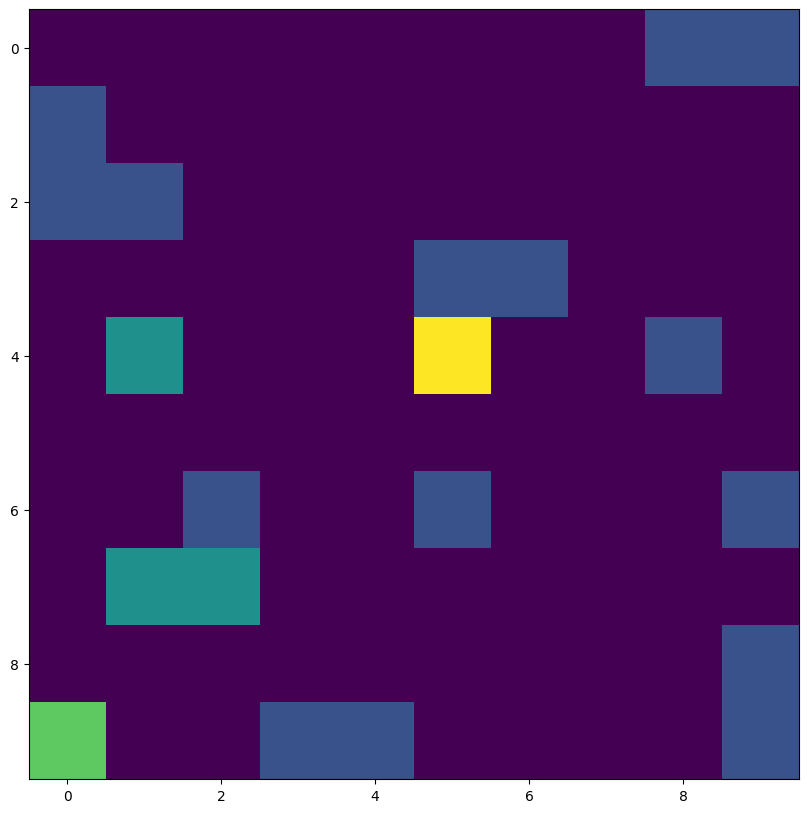

Enemy 1 move: (4, 1)->(4, 0)
Enemy 2 move: (7, 1)->(7, 0)
Enemy 3 move: (7, 2)->(7, 1)


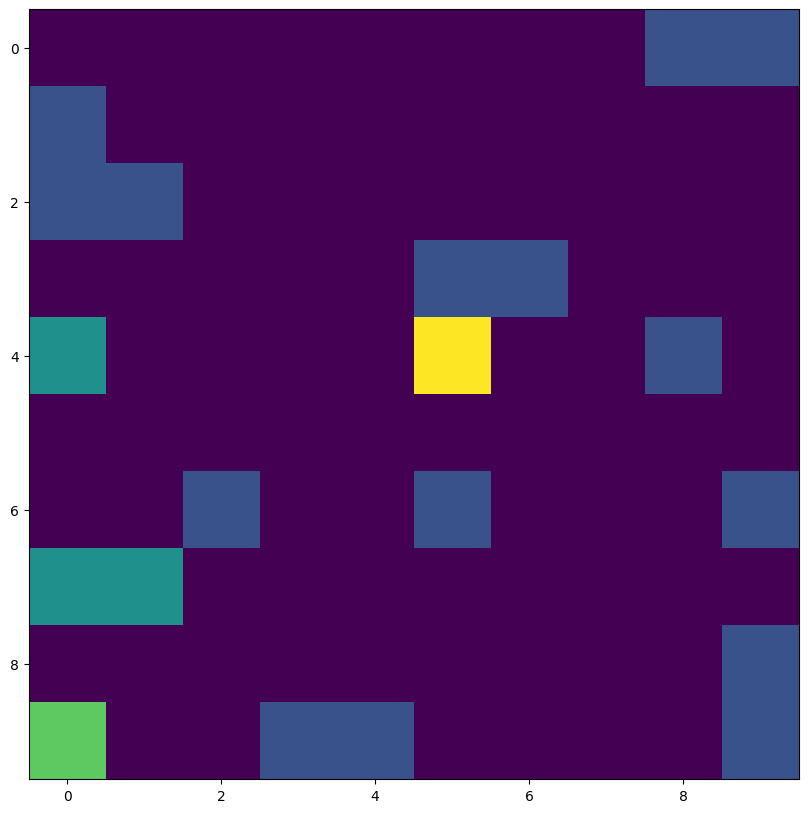

Pacman move: (9, 0)->(9, 1)


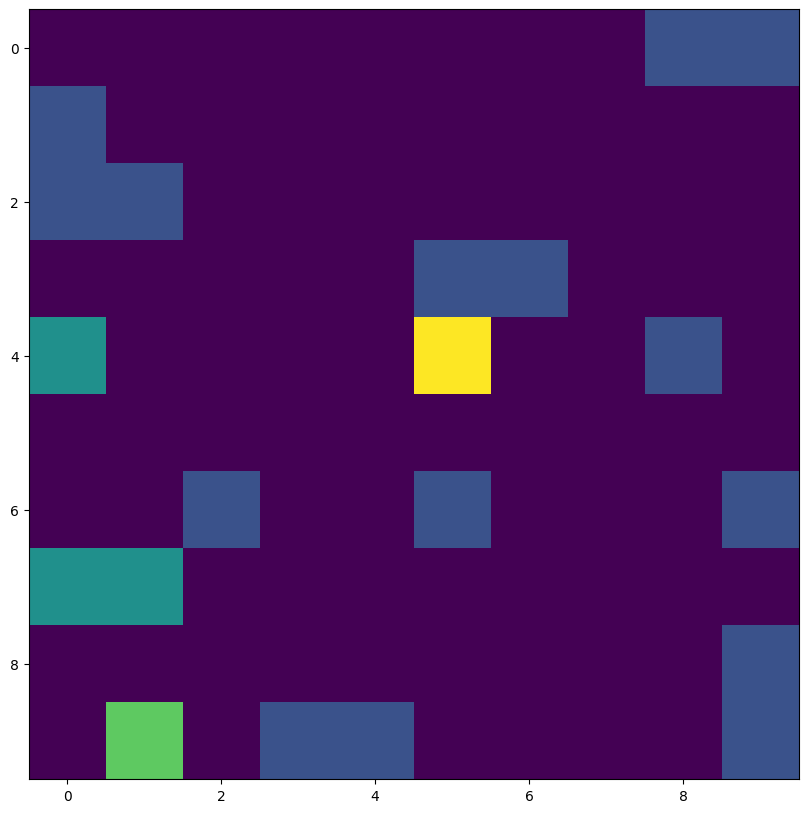

Enemy 1 move: (4, 0)->(4, 1)
Enemy 2 move: (7, 0)->(7, 0)
Enemy 3 move: (7, 1)->(8, 1)


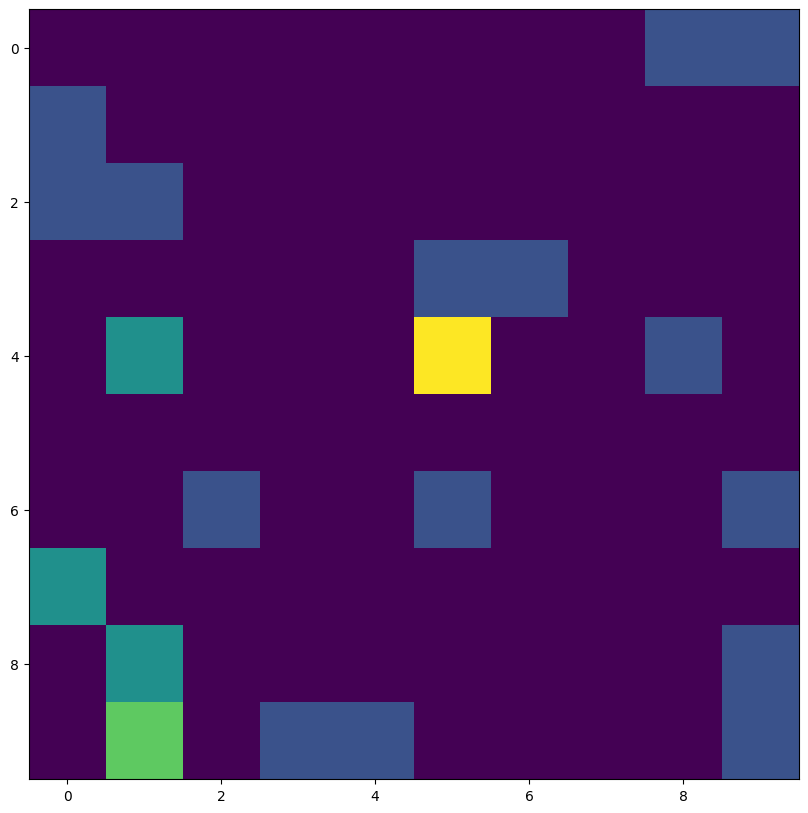

Pacman move: (9, 1)->(9, 0)


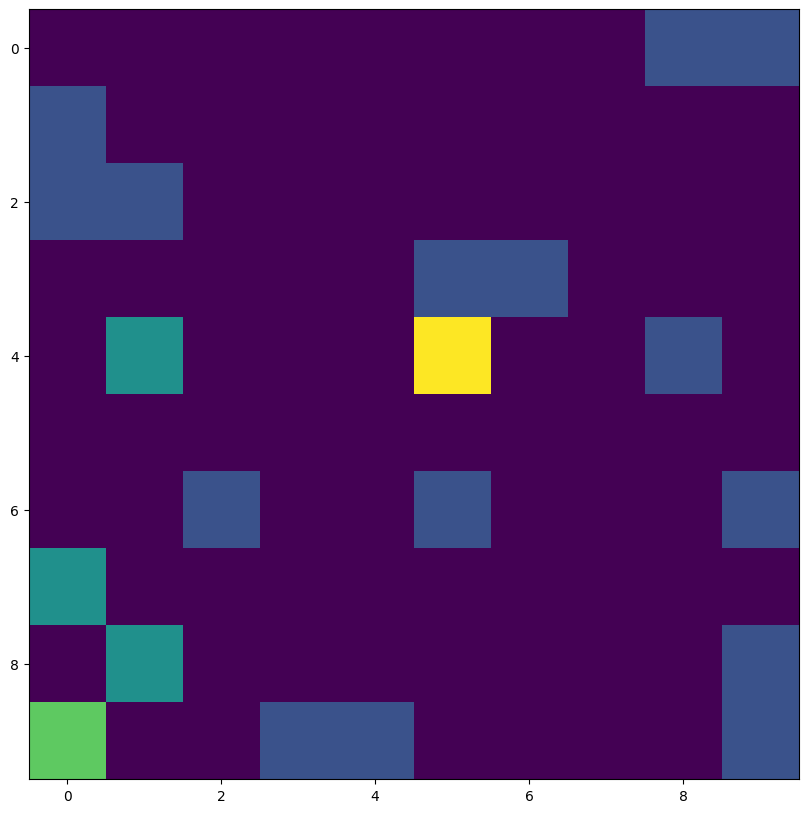

Enemy 1 move: (4, 1)->(4, 0)
Enemy 2 move: (7, 0)->(8, 0)
Enemy 3 move: (8, 1)->(8, 1)


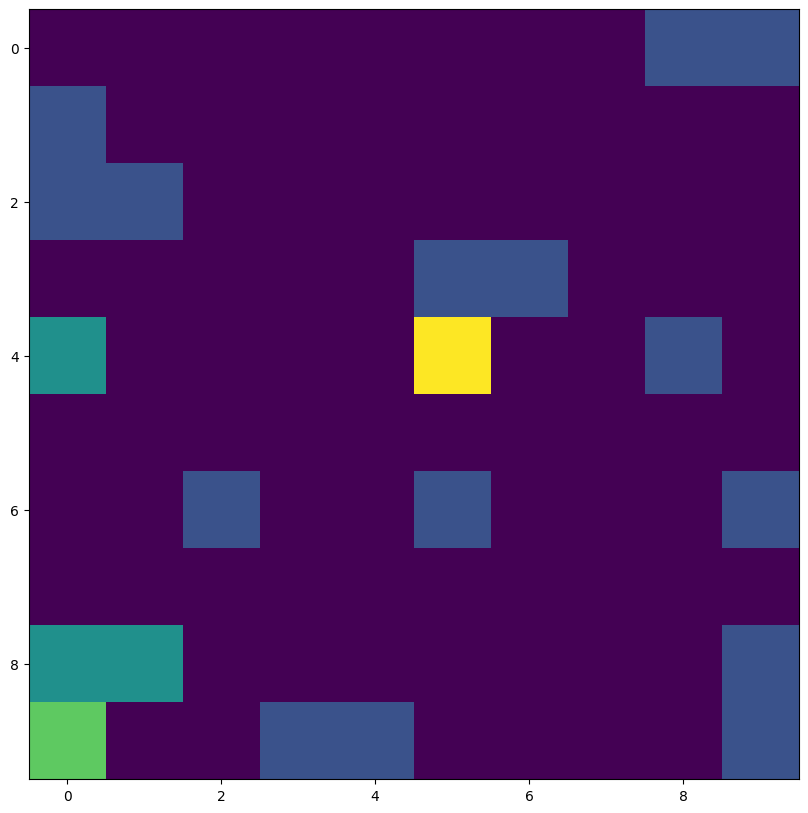

Pacman move: (9, 0)->(9, 1)


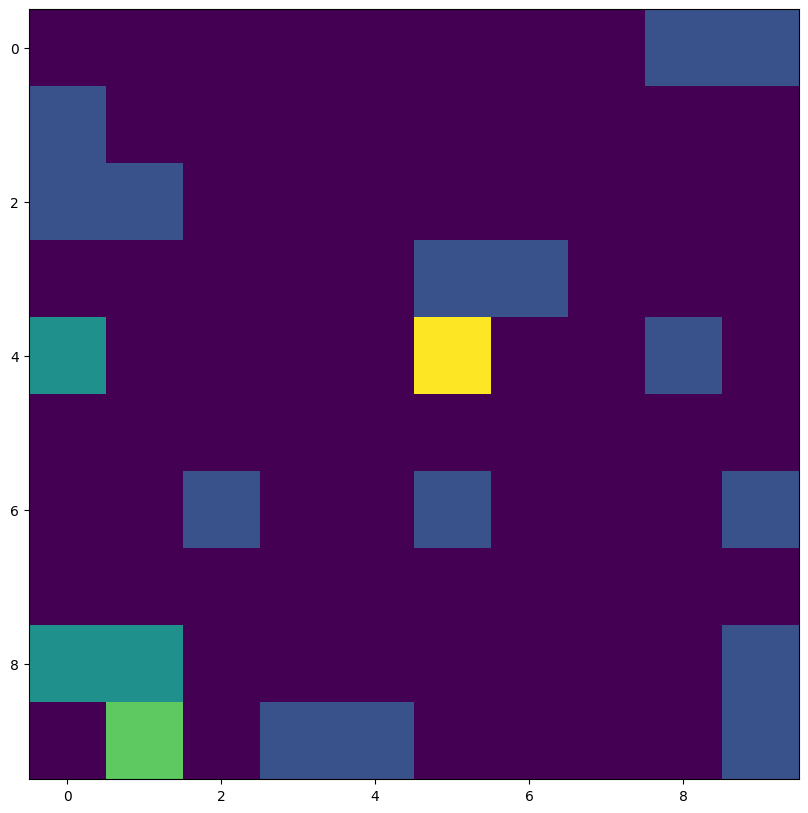

Enemy 1 move: (4, 0)->(4, 1)
Enemy 2 move: (8, 0)->(8, 0)
Enemies win.


In [6]:
game.play()

Initial position:


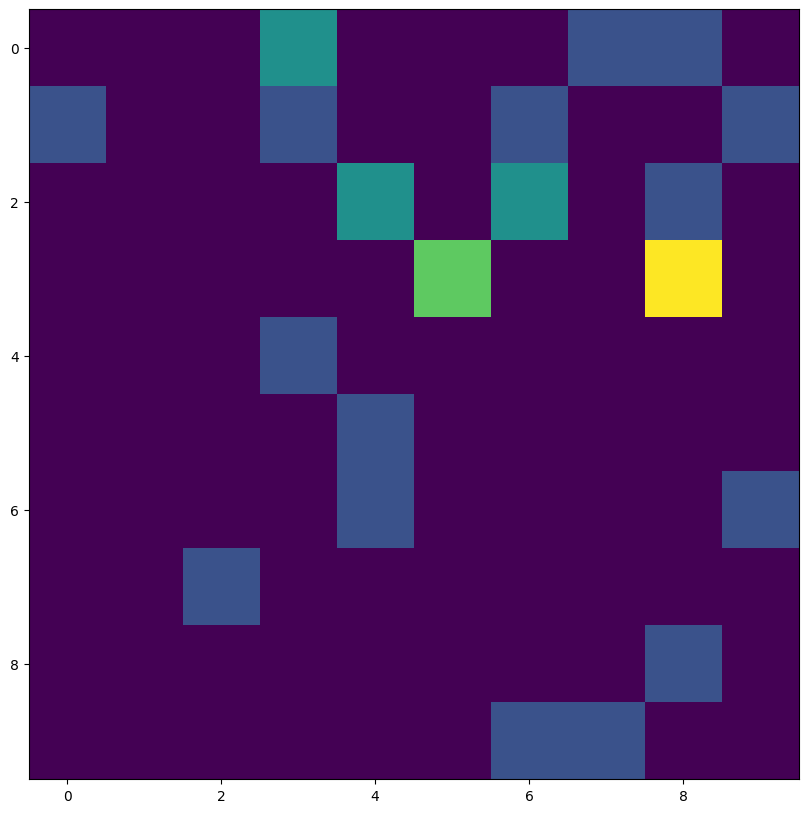

Pacman move: (3, 5)->(3, 4)


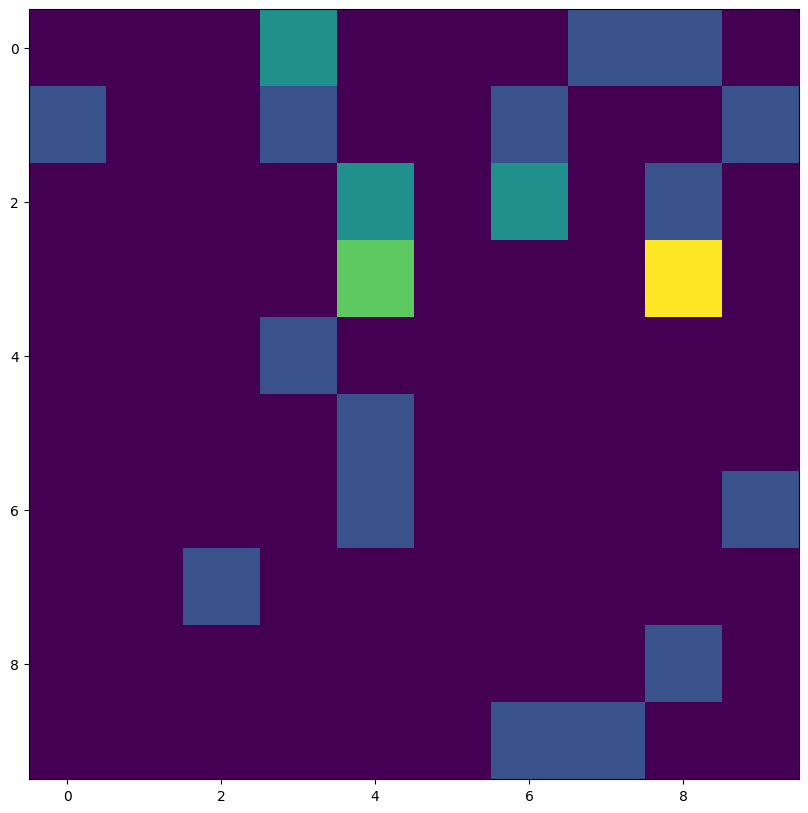

Enemy 1 move: (0, 3)->(0, 4)
Enemies win.


In [7]:
game2 = Game(10, 10, 15, 3, 2)
game2.play(True)